# Experiments

- Datasets:
    - ERA-Interim   (39 years)
    - ERA5          (40 years)
    - EC-Earth      (160 years)
- Train Test:
    - Leave 4 year out Cross Validation
- Methods:
    - McKinnon (PEP)
    - Spatial Covariance (SST)
    - Gradient Boosting Regressor (SST + Indices)

# EC-Earth
Om een goede spreiding van El-Niño/La Niña te krijgen, willen we alle 16 initialisaties van de oceaan gebruiken. Om interjaarlijste variabliteit en model-spin-up problemen te vermijden, kiezen we van elke run enkel het laatste jaar van de 5. Dit om de meest onafhankelijk mogelijke jaren te kiezen.

In [1]:
import sys; sys.path.append('../..')
from heatwave import ERA, Country, utils

import matplotlib.pyplot as plt

from netCDF4 import Dataset, num2date
import numpy as np

import os

In [36]:
INPUT = '/Volumes/Samsung_T5/Thesis/EC-Earth'
OUTPUT = os.path.join(INPUT, '160')

STARTS = range(1, 17)
MEMBERS = range(0, 10)
YEARS = [2039]

# # TOS
# VAR = 'tos'
# FORMAT = 'tos_PD/tos_d_s{0:02d}/tos_d_ECEarth_PD_s{0:02d}r{1:02d}_{2:04d}.nc'
# INDEX = [None, slice(8, 90)]

# # TAS
# VAR = 'tas'
# FORMAT = 'tas_PD_US/tas_d_ECEarth_PD_s{0:02d}r{1:02d}_{2:04d}_US.nc'
# INDEX = []

# # MRLSL
# VAR = 'mrlsl4'
# FORMAT = VAR+'_PD/'+VAR+'_d_s{0:02d}_US/'+VAR+'_d_ECEarth_PD_s{0:02d}r{1:02d}_{2:04d}_US.nc'
# INDEX = []

# PSL
VAR = 'psl'
FORMAT = 'psl_PD/psl_d_s{0:02d}/psl_d_ECEarth_PD_s{0:02d}r{1:02d}_{2:04d}.nc'
INDEX = [None, slice(8, 90)]

OUTPUT = os.path.join(OUTPUT, VAR+'_d_ECEarth_PD_1start_10ens_lastyr.nc')

KWARGS = dict(longitude_key='lon', latitude_key='lat', time_unit='D', time_origin='2000-01-01')

In [37]:
def walk(root: str, path_format: str, starts: list, members: list, years: list):
    for start in starts:
        for member in members:
            for year in years:
                yield os.path.join(root, path_format.format(start, member, year))

In [38]:
if os.path.exists(OUTPUT): os.remove(OUTPUT)

dataset = Dataset(OUTPUT, 'w', format='NETCDF4_CLASSIC')

time_index = 0

for path in walk(INPUT, FORMAT, STARTS, MEMBERS, YEARS):
    
    print(f"\rProcessing {path}", end="")
    
    data = ERA(path, VAR, index=INDEX, **KWARGS)
    
    if time_index == 0:
        time = dataset.createDimension('time', None)
        lat = dataset.createDimension('lat', data.shape[1])
        lon = dataset.createDimension('lon', data.shape[2])
        
        times = dataset.createVariable('time', np.float32, ('time',))
        latitudes = dataset.createVariable('lat', np.float32, ('lat',))
        longitudes = dataset.createVariable('lon', np.float32, ('lon',))
        var = dataset.createVariable(VAR, np.float32, ('time','lat','lon'))
        
        latitudes[:] = data.latitude
        longitudes[:] = data.longitude
        
        # Metadata
        var.author = data.dataset.author
        var.experiment = data.dataset.experiment
        
        times.units = "days since 2000-01-01 12:00:00"
        times.calendar = 'noleap'
        
        latitudes.units = data.dataset['lat'].units
        longitudes.units = data.dataset['lon'].units
        var.units = data.dataset[VAR].units
        
    time_values = data.time.values.ravel() + time_index
    time_length = len(time_values)
        
    var[time_index:time_index+time_length, :, :] = data.data
    times[time_index:time_index+time_length] = time_values
    
    time_index += time_length

dataset.close()

Processing /Volumes/Samsung_T5/Thesis/EC-Earth/psl_PD/psl_d_s16/psl_d_ECEarth_PD_s16r09_2039.nc

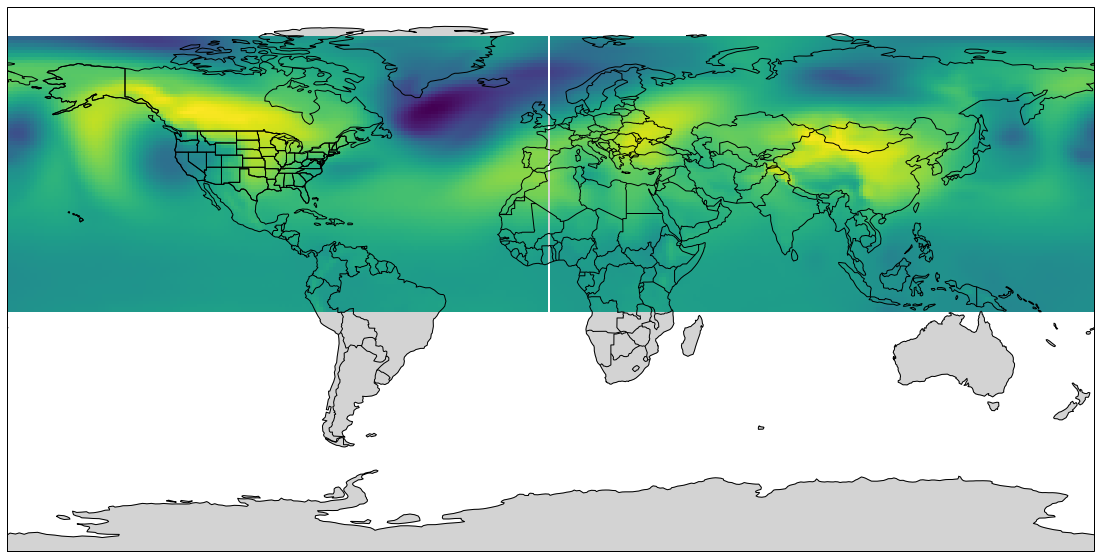

In [40]:
data = ERA(OUTPUT, VAR, index=[[0]], **KWARGS)

utils.plot_earth()
plt.pcolormesh(data.longitude, data.latitude, data.data[0])
plt.show()